In [1]:
import logging
import pathlib
import shutil
import sys
import csv
import os
import itertools
from tqdm import tqdm
logging.basicConfig()

import scipy
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate
from matplotlib import pyplot as plt
from tdc import Evaluator
import numpy as np
import seaborn as sb

from rdkit import Chem
from rdkit.Chem import MACCSkeys

sys.path.append('..')
from sbap.sdf import ChemblSdfReader
from sbap.featurizers.prolif_smina import SminaDockingPersistenceHandler, SminaConfig, DockedProlifFingerprintFeaturizer, SminaDockingScoreFeaturizer

In [4]:
sdf_file = pathlib.Path("../molecules/human_serum_albumin_CHEMBL_data.sdf")
protein_pdb_file = pathlib.Path("../molecules/4la0_human_serum_albumin_cleaned_without_ligand.pdb")
docked_ligands_target_directory = pathlib.Path("../molecules/albumin_bis")

config = SminaConfig(
    center_x=-17.654, center_y=-13.090, center_z=10.471, size_x=30, size_y=30, size_z=30, exhaustiveness=6,
)
persistent_docking_handler = SminaDockingPersistenceHandler.create(
    smina_config=config,
    docked_ligands_target_directory=str(docked_ligands_target_directory),
    logging_level=logging.INFO,
)
fingerprint_featurizer = DockedProlifFingerprintFeaturizer.create(
    logging_level=logging.INFO,
)
docking_score_featurizer = SminaDockingScoreFeaturizer(logging.INFO)

# persistent_docking_handler.dock(protein_pdb_file, sdf_file, starting_batch=1, batch_size=1)

INFO:SminaDockingPersistenceHandler:Starting docking process with batch_size=1 and starting_batch=1...
INFO:SminaDockingPersistenceHandler:Skipping batch. 1 skipped batches left...
  2%|██                                                                                                                           | 9/530.0 [01:36<1:51:20, 12.82s/it][13:50:57] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:50:57] *****: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
  2%|██▎                                                                                                                         | 10/530.0 [01:57<2:10:55, 15.11s/it][13:51:11] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
  3%|███▉                                                                                                                        | 17/530.0 [02:52<1:02:56,  7.36s/it]ERROR:SminaDoc

 35%|███████████████████████████████████████████▊                                                                                 | 186/530.0 [27:18<49:48,  8.69s/it][14:16:22] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
 35%|████████████████████████████████████████████▎                                                                                | 188/530.0 [27:32<45:53,  8.05s/it][14:16:37] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
 36%|████████████████████████████████████████████▌                                                                                | 189/530.0 [27:37<40:43,  7.17s/it][14:16:42] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
 36%|████████████████████████████████████████████▊                                                                                | 190/530.0 [27:42<37:25,  6.60s/it]ERROR:SminaDockingPersis

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 344/530.0 [53:15<27:18,  8.81s/it][14:42:27] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 355/530.0 [1:02:42<5:18:37, 109.25s/it]ERROR:SminaDockingPersistenceHandler:Batch 355 encountered error: Bad Conformer Id
 67%|█████████████████████████████████████████████████████████████████████████████████▎                                       | 356/530.0 [1:02:55<3:52:33, 80.19s/it]ERROR:SminaDockingPersistenceHandler:Batch 356 encountered error: Bad Conformer Id
 68%|█████████████████████████████████████████████████████████████████████████████████▉                                       | 359/530.0 [1:03:31<1:38:13, 34.47s/it][14:52:39] *****: Warning - no explicit hydrogens in mol2 file but

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 504/530.0 [1:33:46<03:28,  8.03s/it][15:22:57] *****: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 519/530.0 [1:36:08<01:49,  9.95s/it][15:25:08] UFFTYPER: Unrecognized atom type: S_6+6 (9)
[15:25:18] *****: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 527/530.0 [1:40:21<01:41, 33.88s/it]ERROR:SminaDockingPersistenceHandler:Batch 527 encountered error: Bad Conformer Id
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 529/530.0 [1:40:58<00:11, 11.45

## Transformacja nr 0 (opcjonalna) - dodaj MACCS

In [5]:
def get_input_data(include_maccs=False):
    fingerprint_featurizer.fit(protein_pdb_file, docked_ligands_target_directory)
    X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
    if include_maccs:
        # sdf_reader = Chem.rdmolfiles.SDMolSupplier(str(sdf_file))
        reader = ChemblSdfReader()
        molecules = reader.parse(sdf_file)
        maccs = []
        cnt = 0
        labels_csv = os.path.join(docked_ligands_target_directory, 'labels.csv')
        with open(labels_csv, 'r') as file:
            for result_id, score, label, cdId in csv.reader(file):
                number = int(cdId[1:-1])
                while molecules[cnt]['cdId'] != number:
                    cnt += 1
                mol = Chem.rdmolfiles.MolFromMolBlock(molecules[cnt]['mol'])
                fp = MACCSkeys.GenMACCSKeys(mol).ToBitString()
                maccs.append(MACCSkeys.GenMACCSKeys(mol))
                cnt += 1
        maccs_x = np.array(maccs, dtype='i')
        print(f'maccs.shape = {maccs_x.shape}')
        X = np.concatenate((X, maccs_x), axis=1)
    return X, y

In [23]:
X, Y = get_input_data(include_maccs=False)
print(f'input shape: {X.shape}')

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

input shape: (493, 153)


## Transformacja nr 1 - przekształć y na skalę logarytmiczną

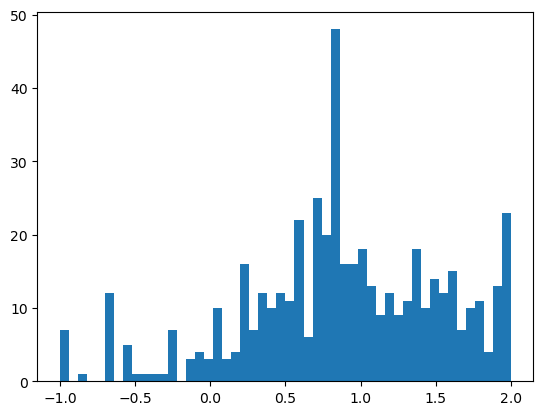

In [8]:
dataset_siz = X.shape[0]
y = np.array(Y, dtype='f')
y = np.log10(100.1 - y)
count, bins, _ = plt.hist(y, bins=50)
plt.show()

Czy liczba zapalonych bitów fingerprintu koreluje z docking score? Chyba tak

## Transformacja nr 2 
### usuń punkty, dla których docking score jest niespodziewanie mały

(493, 320)
new shape: (493, 320)


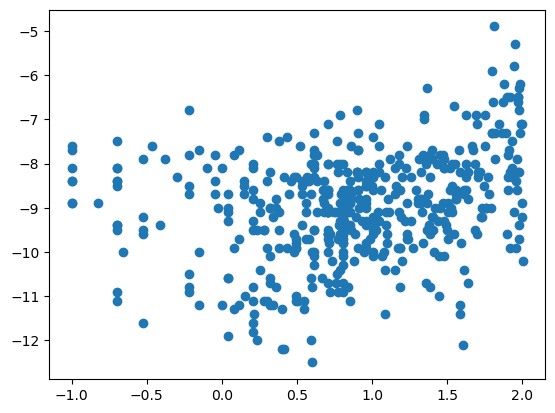

In [9]:
print(X.shape)
good_indices = np.argwhere(X[:, 0] < -2).flatten()
X = X[good_indices, :]
y = y[good_indices]
print(f'new shape: {X.shape}')
A = np.sum(X[:, 1:], axis=1)
plt.scatter(y, X[:, 0])
plt.show()

## Transformacja nr 3 (opcjonalna)
### usuń bity, które są zapalone tylko dla kilku (<CUTOFF_THRESHOLD) ligandów

In [12]:
def truncate(X, Y, CUTOFF_THRESHOLD=20):
    sums = np.sum(X, axis=0)
    good_idces = np.argwhere(sums > CUTOFF_THRESHOLD).flatten()
    X_trunc = X[:, good_idces]
    return X_trunc, Y

X_trunc, y_trunc = truncate(X, y, 5)
print(X_trunc.shape)

(493, 192)


## Transformacja nr 4 (opcjonalna)
### usuń część danych tak aby rozkład danych bardziej przypominał rozkład normalny

(493, 192)
(493,)


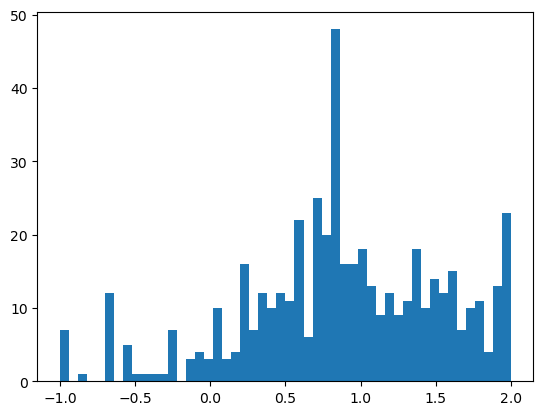

In [17]:
def pseudonormalize(X, Y, THRESHOLD=100):
    n_bins = 50
    y_min = np.min(Y)
    y_max = np.max(Y) + 0.0001
    limits = []

    good_indices = []
    for i in range(51):
        limits.append(y_min + (i * (y_max - y_min) / n_bins))
    for i in range(50):
        bin_indices = np.argwhere(np.logical_and(Y >= limits[i], Y < limits[i+1])).flatten()
        if len(list(bin_indices)) > THRESHOLD:
            bin_indices = bin_indices[:THRESHOLD]
        good_indices = good_indices + list(bin_indices)
    tX = X[good_indices]
    tY = Y[good_indices]

    print(tX.shape)
    print(tY.shape)
    count, bins, _ = plt.hist(tY, bins=50)
    plt.show()
    return tX, tY

X_norm, y_norm = pseudonormalize(X_trunc, y_trunc, 100)

# Porównanie różnych modeli regresji

In [18]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [19]:
"""
uses 5-cross validation to estimate model
"""
def evaluate_regression_model(model, X, y):
    scoring = ['neg_mean_absolute_error', 'r2']
    results = cross_validate(estimator=model, X=X, y=y, cv=5, scoring=scoring)
    return np.mean(results['test_r2']) + np.mean(results['test_neg_mean_absolute_error'])

def test_regression_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)

    fig, ax = plt.subplots()
    ax.axline((0, 0), slope=1)
    
    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge

# you can try multiple configurations
regression_model_list = [
    (RandomForestRegressor, {
        'n_estimators': [300, 500, 800], 
        'min_samples_leaf': [2, 4, 8], 
        'max_features': ['log2', 'sqrt', None]
    }),
    (MLPRegressor, {
        'hidden_layer_sizes': [(100,), (300,), (256, 128), (128, 64, 32), (100, 100)], 
        'activation': ['logistic', 'tanh', 'relu'],
        'early_stopping': [True, False]
    }),
    (Ridge, {
        'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    }),
]

In [21]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

scores = []
best_score = -10.0
best_params = ()
best_model_type = None

x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2)

for model_type in regression_model_list:
    for params in tqdm(my_product(model_type[1])):
        model = model_type[0](**params)
        score = evaluate_regression_model(model, x_train, y_train)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_model_type = model_type[0]
            best_params = params
    print(f'done with {model_type[0]}')
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')

27it [01:40,  3.74s/it]


done with <class 'sklearn.ensemble._forest.RandomForestRegressor'>


30it [01:01,  2.04s/it]


done with <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>


10it [00:00, 82.46it/s]

done with <class 'sklearn.linear_model._ridge.Ridge'>
best_model_type = <class 'sklearn.ensemble._forest.RandomForestRegressor'>, best_params = {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': None}, best_score = -0.12444657370092954


best_model_type = <class 'sklearn.ensemble._forest.RandomForestRegressor'>, best_params = {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': None}, best_score = -0.12444657370092954
on train set: RMSE, MAE, R2 = 0.27076331695692235, 0.18796717626890483, 0.833270607222141
on test set: RMSE, MAE, R2 = 0.558202954451963, 0.4063221024557748, 0.3614645318409363


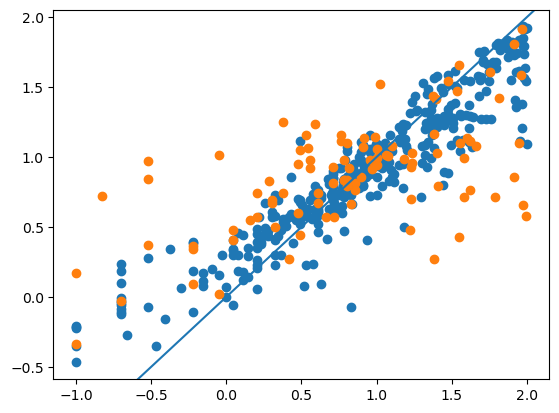

In [22]:
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')
model = best_model_type(**best_params)
test_regression_model(model, x_train, x_test, y_train, y_test)

## Variable importance

max contribution: 0.037498949451763526, min contribution: 3.1263732505746925e-05
the docking score parameter contributed 0.001078445487610113
on average, a SIFT parameter contributed 0.0034352134388259303
on average, a MACCS parameter contributed 0.005014769598129168


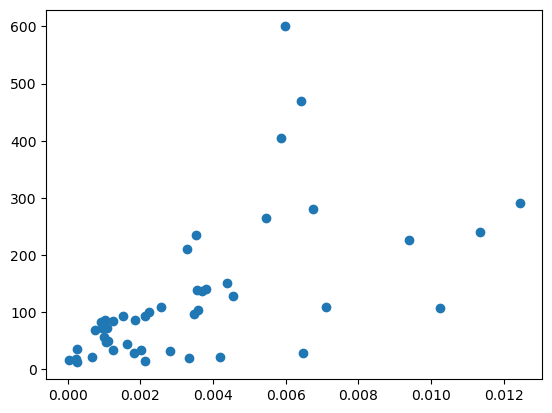

In [24]:
np.set_printoptions(precision=4, suppress=True)
importance = model.feature_importances_
importance_sift = importance[1:-167]
sum_sift = np.sum(X_norm[:, 1:-167], axis=0)
plt.scatter(importance_sift, sum_sift)
print(f'max contribution: {np.max(importance)}, min contribution: {np.min(importance)}')
print(f'the docking score parameter contributed {importance[0]}')
print(f'on average, a SIFT parameter contributed {np.mean(importance_sift)}')
print(f'on average, a MACCS parameter contributed {np.mean(importance[-167:])}')
plt.show()

# Porównanie modeli klasyfikacji binarnej

In [24]:
def get_binary_classification_data(X, y, threshold = 0.8):
    high_pic50 = np.argwhere(y > threshold).flatten()
    yb = np.zeros(y.shape)
    yb[high_pic50] = 1.0
    yb = np.array(yb, dtype='i')
    print(f'fraction of 1\'s: {sum(yb) / len(yb)}')
    return X, yb

In [25]:
acc = Evaluator(name = 'Accuracy')
prec = Evaluator(name = 'Precision')
recall = Evaluator(name = 'Recall')

def evaluate_classification_model(model, X, yb):
    scoring = ['accuracy', 'precision', 'recall']
    results = cross_validate(estimator=model, X=X, y=yb, cv=5, scoring=scoring)
    return np.mean(results['test_accuracy']) + 3 * np.mean(results['test_precision']) + 5 * np.mean(results['test_recall'])


def test_classification_model(model, xb_train, xb_test, yb_train, yb_test):
    model.fit(xb_train, yb_train)

    predictions = model.predict(xb_train)  
    print(predictions[:30])
    print(yb_train[:30])
    acc_score = acc(yb_train, predictions)
    prec_score = prec(yb_train, predictions)
    recall_score = recall(yb_train, predictions)
    print(f'on train set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

    predictions = model.predict(xb_test) 
    print(predictions[:30])
    print(yb_test[:30])
    acc_score = acc(yb_test, predictions)
    prec_score = prec(yb_test, predictions)
    recall_score = recall(yb_test, predictions)
    print(f'on test set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

classification_model_list = [
    (RandomForestClassifier, {}),
    (AdaBoostClassifier,     {'n_estimators': [15, 31, 61]}),
    # (SVC,                    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.3, 1.0, 3.0]}),
    (SVC,                    {'kernel': ['poly', 'sigmoid'], 'C': [0.3, 1.0, 3.0]}),
    (MLPClassifier,          {'hidden_layer_sizes': [80, 50], 'alpha': [0.3, 1.0, 3.0]}),
    (LogisticRegression,     {'penalty': ['l1', 'l2'], 'C': [0.1, 0.3], 'solver': ['liblinear']}),
]

In [28]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

best_params_dict = {}

for threshold in [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]:
    scores = []
    best_score = -10.0
    best_params = ()
    best_model_type = None
    X, yb = get_binary_classification_data(X_norm, y_norm, threshold)
    print(X.shape)
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)

    for model_type in classification_model_list:
        for params in my_product(model_type[1]):
            model = model_type[0](**params)
            score = evaluate_classification_model(model, xb_train, yb_train)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_model_type = model_type[0]
                best_params = (model_type[0], params)
    print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')
    best_params_dict[threshold] = best_params

fraction of 1's: 0.718052738336714
(493, 192)
best_model_type = <class 'sklearn.linear_model._logistic.LogisticRegression'>, best_params = (<class 'sklearn.linear_model._logistic.LogisticRegression'>, {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear'}), best_score = 7.902388474467147
fraction of 1's: 0.6693711967545639
(493, 192)
best_model_type = <class 'sklearn.svm._classes.SVC'>, best_params = (<class 'sklearn.svm._classes.SVC'>, {'kernel': 'sigmoid', 'C': 0.3}), best_score = 7.645260057989937
fraction of 1's: 0.5862068965517241
(493, 192)
best_model_type = <class 'sklearn.svm._classes.SVC'>, best_params = (<class 'sklearn.svm._classes.SVC'>, {'kernel': 'sigmoid', 'C': 0.3}), best_score = 7.105249167836702
fraction of 1's: 0.4746450304259635
(493, 192)
best_model_type = <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, best_params = (<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, {'n_estimators': 31}), best_score = 6.261200172815233
fraction of 1's: 0.

In [30]:
print(best_params_dict)

for threshold, best_params in best_params_dict.items():
    X, yb = get_binary_classification_data(X_norm, y_norm, threshold)
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)
    best_model_type = best_params[0]
    params = best_params[1]
    print(f'')
    print(f'best_model_type: {best_model_type}')
    print(f'best params: {best_params}')
    model = best_model_type(**params)
    test_classification_model(model, xb_train, xb_test, yb_train, yb_test)

{0.6: (<class 'sklearn.linear_model._logistic.LogisticRegression'>, {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear'}), 0.7: (<class 'sklearn.svm._classes.SVC'>, {'kernel': 'sigmoid', 'C': 0.3}), 0.8: (<class 'sklearn.svm._classes.SVC'>, {'kernel': 'sigmoid', 'C': 0.3}), 0.9: (<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, {'n_estimators': 31}), 1.0: (<class 'sklearn.linear_model._logistic.LogisticRegression'>, {'penalty': 'l1', 'C': 0.3, 'solver': 'liblinear'}), 1.1: (<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, {'hidden_layer_sizes': 50, 'alpha': 1.0})}
fraction of 1's: 0.718052738336714

best_model_type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
best params: (<class 'sklearn.linear_model._logistic.LogisticRegression'>, {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear'})
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
[1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1]
on train set: Accuracy, Precis